# Transformer
- Paper Implementation : "Attention is all you need (2017)" 
---
**Description:**

**1. Model Architecture:**

<img src = 'https://production-media.paperswithcode.com/methods/new_ModalNet-21.jpg' width='400' height='400' /> </img> <br>

Figure1. Architecture of Transformer(VASWANI, et al,2017) <br></br>

**2. Characteristics of Transformer:**

- Multihead Attention :  allows the model to attend to different parts of the input sequence simultaneously.

- Position wise feed forward : feed-forward neural network that applies to each position of the sequence independently

- Encoder - Decoder Architecture: The encoder takes a sequence of input data and converts it into a sequence of hidden states. The decoder then takes these hidden states and generates a sequence of output data.

- Positional Encoding: added to the embedding layer of the transformer model. This allows the model to learn long-range dependencies between tokens in a sequence. Without positional encoding, the model would only be able to learn local dependencies between neighboring tokens.

**3. Model Metrics:**

- PPL(Perplexity): metric for language model. Find out how well a language model predicts the next word in a sequence
   - Less PPL score indicates better Language Model 
   - Can be used in Text generation, Machine translation, Speech recognition, Question answering

- BLEU(Bilingual Evaluation Understudy): useful metric for evaluating the quality of machine translation systems 
  - calculated by comparing the machine-translated text to a reference translation
  - BLEU scores range from 0 to 1
  - higher BLEU score indicates better translation

**4. Dataset:**
- Multi30K : Multilingual English-German Image Descriptions

**5. System Environment:**
- Goolge colab pro plus GPU : A100
- Visual Studio Code

---
**Reference**

[1] Deep-Learning-Paper-Review-and-Practice,ndb796, accessed May12.2023, https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb


[2] Elliott, D., Frank, S., Sima'an, K., & Specia, L. (2016). Multi30k: Multilingual english-german image descriptions. arXiv preprint arXiv:1605.00459.
https://aclanthology.org/W16-3210.pdf

[3] Vaswani, Ashish & Shazeer, Noam & Parmar, Niki & Uszkoreit, Jakob & Jones, Llion & Gomez, Aidan & Kaiser, Lukasz & Polosukhin, Illia. (2017). Attention Is All You Need. https://arxiv.org/pdf/1706.03762.pdf



#### <b>Set the Library for the BLEU score</b>

* <b>Restart Runtime</b> 

In [1]:
# Instal Torchtext with designated version 
# !pip install torchtext==0.6.0

**Load Library**

In [2]:
# Data Preprocessing
import spacy
from torchtext.data import Field, BucketIterator

# Dataset
from torchtext.datasets import Multi30k

# Pytorch
import torch
import torch.optim as optim

# Training time check
import time
import math
import random
from tqdm import tqdm 

# Visualiztion
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# BLEU score
from torchtext.data.metrics import bleu_score

In [3]:
# Goolge Colab Environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Data Preprocessing**

* **spaCy Library**: 
- use spaCy for sentence Tokenization and Tagging 
- install English and Deutsch preprocessing module

In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [5]:
# Download spacy Data
%%capture
!python -m spacy download en
!python -m spacy download de

In [6]:
# Load library and language data
spacy_en = spacy.load('en_core_web_sm') # English tokenization
spacy_de = spacy.load('de_core_news_sm') # Deutch tokenization

In [7]:
# Check tokenization tool
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
    print(f"Index {i}: {token.text}")

Index 0: I
Index 1: am
Index 2: a
Index 3: graduate
Index 4: student
Index 5: .


**Define English and German Tokenization function**

In [8]:
# Function for Deutsch sentence tokenization 
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# Function for English sentence tokenization 
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

**Field** : this library shows descriptions for preprocessing of dataset 
- set <b>Batch first values as True</b>
- Translation objective: 
    * SRC(source): Deutsch
    * TRG(target): English

In [9]:
# Load Library and define SRC and TRG
SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

**Load Dataset: Multi30k**
- import dataset : Multi30k
- split dataset to train, valid, and test

In [10]:
# Load Dataset and split data
train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

In [11]:
# Check out the length of each dataset 
print(f"Size of Training dataset: {len(train_dataset.examples)}")
print(f"Size of Validation dataset: {len(valid_dataset.examples)}")
print(f"Size of Testing dataset: {len(test_dataset.examples)}")

Size of Training dataset: 29000
Size of Validation dataset: 1014
Size of Testing dataset: 1000


In [12]:
# Select one sample for train dataset and check out the data
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


**Create English and Deutsch Vocab**:
- Use <b>"build_vocab"</b> from Field libary 
- Select the words that has shown at least twice 


In [13]:
# Build Vocab
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7853
len(TRG): 5893


In [14]:
print(TRG.vocab.stoi["abcabc"]) # words Not included: 0
print(TRG.vocab.stoi[TRG.pad_token]) # Padding: 1
print(TRG.vocab.stoi["<sos>"]) # <Start of Sentence, sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <End of Sentence, eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


**Words should be arranged in order of sentence to the network**
- using <b>Bucketiterator</b> make the length of words resmeble in each sentences.  

**Set Device, Dataloader**
- define device, batchsize 
- define dataloader

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

In [16]:
# Define data loader 
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)


# test index and size of first batch 
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"Size of first batch : {src.shape}")

    # Print the information in one batch of sentence
    for i in range(src.shape[1]):
        print(f"index {i}: {src[0][i].item()}") # [Seq_num, Seq_len]

    # Check the first batch only
    break

Size of first batch : torch.Size([128, 24])
index 0: 2
index 1: 5
index 2: 3484
index 3: 415
index 4: 5
index 5: 1537
index 6: 9
index 7: 64
index 8: 8
index 9: 0
index 10: 2018
index 11: 42
index 12: 39
index 13: 4021
index 14: 235
index 15: 28
index 16: 307
index 17: 4
index 18: 3
index 19: 1
index 20: 1
index 21: 1
index 22: 1
index 23: 1


#### **Multi Head Attention**

* Attention get <b>three components</b> as input:
    * <b>queries</b>
    * <b>keys</b>
    * <b>values</b>
    * in this implementation <b>Query, Key, and Value</b> have same dimension
* Hyperparameter
    * **hidden_dim**: embedding dimension of one sentence
    * **n_heads**: number of heads = number of scaled dot-product attention
    * **dropout_ratio**: dropout rate (for regularization)

In [17]:
# Define Multihead attention layer
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # embedding dimension
        self.n_heads = n_heads # number of head : number of each attention concept (different from each other)
        self.head_dim = hidden_dim // n_heads # embedding dimension of each head 

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # FC layer whcih applies to Query 
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # FC layer whcih applies Key 
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # FC layer whcih applies Value 

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → transform to n_heads X head_dim shape
        # induce n_heads(h) to different attention concept(for training)
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Calculate Attention Energy 
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # When using mask
        if mask is not None:
            # fill the value if  mask value =0 as  -1e10
            energy = energy.masked_fill(mask==0, -1e10)

        # calculate attention score: statistical value of each sentence 
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # Calculate Scaled Dot-Product Attention
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

#### **Position-wise Feedforward **

* input and output dimensions are equivalent to each other 
* Hyperparameter:
    * **hidden_dim**: embedding dimension of single word 
    * **pf_dim**: inner embeding dimension of Feedforward layer
    * **dropout_ratio**: dropout rate

In [18]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

#### **Encoder layer**

* Define single encoder layer 
    * input and output dimensions are equivalent to each other 
    * for this reason transformer encoder overlapping many times 
* Hyperparameter
    * **hidden_dim**: embedding dimension of single word 
    * **n_heads**: number of head = number of scaled dot-product attention
    * **pf_dim**: inner embeding dimension of Feedforward layer원
    * **dropout_ratio**: dropout rate
* &lt;pad&gt; set mask value as "0" about token

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # duplicate one embedding then input Query, Key, Value
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # If needed use mask matrix in order to regulate words of attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

#### **Encoder Architecture**

* Define Encoder architecture
* Hyperparameter:
    * **input_dim**: one hot encoding dimension of single word 
    * **hidden_dim**: embedding dimension of single word 
    * **n_layers**: number of encoder layer for internal usage 
    * **n_heads**: number of head = number of scaled dot-product attention
    * **pf_dim**: inner embedding dimension of Feedforward layer
    * **dropout_ratio**: dropout rate
    * **max_length**: maximum number of words in a sentence 
* train <b>positional embedding</b>
    * its different way of training from the original paper but this training method commonly used for modern transformer architecture such as BERT
* &lt;pad&gt; set mask value as "0" about token

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # Add source sentence embedding to positinal embedding 
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # activate forward by getting through all encoder layers in order 
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # return last layer's output 

#### **Decoder layer**

* Define single Decoder layer 
    * input and output dimensions are equivalent to each other 
    * for this reason transformer decoder overlapping many times
    * Decoder layer use two Multi-Head Attention layers
* Hyperparameter:
    * **hidden_dim**: embedding dimension of single word 
    * **n_heads**: number of head = number of scaled dot-product attention
    * **pf_dim**: inner embeding dimension of Feedforward laye
    * **dropout_ratio**: dropout rate
* Source sentence: set mask as '0' for source sentence 's &lt;pad&gt; token 
* Target sentence : use mask for target sentence why? make sure not aware of next words but only train previous word so that it can predict next word. 




In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # Form Attention for output of encoder(enc_src) 
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # use decoder's query for encoder attention 
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

#### **Decoder Architecture**

* Define Decoder architecture
* Hyperparameter:
    * **output_dim**: one hot encoding dimension of single word 
    * **hidden_dim**: embedding dimension of single word 
    * **n_layers**: number of encoder layer for internal usage 
    * **n_heads**: number of head = number of scaled dot-product attention
    * **pf_dim**: inner embedding dimension of Feedforward layer
    * **dropout_ratio**: dropout rate
    * **max_length**: maximum number of words in a sentence 

* train <b>positional embedding</b>
    * its different way of training from the original paper but this training method commonly used for modern transformer architecture such as BERT




* for the Inference : use decoder repeatedly like Seq2Seq
    * training period : can find out the output sentence   
* Source sentence: set mask as '0' for source sentence 's &lt;pad&gt; token
* Target sentence : use mask for target sentence why? make sure not aware of next words but only train previous word so that it can predict next word. 


In [22]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # apply for both source mask and target mask 
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

#### **Transformer Architecture**
- define Transformer model
- all data coming through encoder and decoder to print out the whole sentence 


In [23]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # Set mask as '0' for source sentence 's <pad> token 
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # Make mask for target sentence : in order to cover next word 
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (mask sample)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (mask sample)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

#### **Training Preparation**

- Set Hyperparameter
- define source & target pad index
- define encoder decoder
- define Transformer Model
- Set weight initialization

In [24]:
# Hyperparameter
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [25]:
# define source pad index and target pad index 
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# define Encoder(enc) and Decoder(dec)
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# define Transformer model
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [26]:
# Model summary
print(model)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

In [27]:
# Optimizer
LEARNING_RATE = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Criterion
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

* **Weight initialization**
- initialize parameters of weight 

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [29]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

**Training Loop**

In [30]:
# Training function
def train(model, iterator, optimizer, criterion, clip):
    model.train() # set training mode
    epoch_loss = 0

    # Check out the entire training data
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # exclude las index (<eos>) of output word 
        # start with <sos> for input 
        output, _ = model(src, trg[:,:-1])

        # output: [batch size, trg_len - 1, output_dim]
        # trg: [batch size, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # exclude index 0 <sos > of output word 
        trg = trg[:,1:].contiguous().view(-1)

        # output: [batch size * trg_len - 1, output_dim]
        # trg: [batch size * trg len - 1]

        # calculate loss by comparing model's output and target sentence 
        loss = criterion(output, trg)
        loss.backward() # calculate gradient) 

        # activate gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update parameter
        optimizer.step()

        # calculate total loss 
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [31]:
# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval() # set evaluation mode
    epoch_loss = 0

    with torch.no_grad():
        # check out the entire evaluation data 
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # exclude las index (<eos>) of output word 
            # start with <sos> for input 
            output, _ = model(src, trg[:,:-1])

            # output: [batch size, trg_len - 1, output_dim]
            # trg: [batch size, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # exclude index 0 <sos > of output word 
            trg = trg[:,1:].contiguous().view(-1)

            # output: [batch size * trg_len - 1, output_dim]
            # trg: [batch size * trg len - 1]

            # calculate loss by comparing model's output and target sentence 
            loss = criterion(output, trg)

            # calculate total loss 
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

**Set epoch for training**

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
# epoch per training

N_EPOCHS = 200
CLIP = 1
best_valid_loss = float('inf')

for epoch in tqdm(range(N_EPOCHS)):
    start_time = time.time() # start of time

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # end of time
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

  0%|          | 1/200 [00:08<27:56,  8.42s/it]

Epoch: 01 | Time: 0m 8s
	Train Loss: 5.677 | Train PPL: 292.012
	Validation Loss: 4.195 | Validation PPL: 66.347


  1%|          | 2/200 [00:16<27:01,  8.19s/it]

Epoch: 02 | Time: 0m 7s
	Train Loss: 3.979 | Train PPL: 53.440
	Validation Loss: 3.495 | Validation PPL: 32.946


  2%|▏         | 3/200 [00:23<25:36,  7.80s/it]

Epoch: 03 | Time: 0m 7s
	Train Loss: 3.491 | Train PPL: 32.834
	Validation Loss: 3.120 | Validation PPL: 22.652


  2%|▏         | 4/200 [00:31<24:54,  7.63s/it]

Epoch: 04 | Time: 0m 7s
	Train Loss: 3.159 | Train PPL: 23.539
	Validation Loss: 2.837 | Validation PPL: 17.058


  2%|▎         | 5/200 [00:38<24:35,  7.57s/it]

Epoch: 05 | Time: 0m 7s
	Train Loss: 2.895 | Train PPL: 18.079
	Validation Loss: 2.619 | Validation PPL: 13.721


  3%|▎         | 6/200 [00:46<24:23,  7.54s/it]

Epoch: 06 | Time: 0m 7s
	Train Loss: 2.679 | Train PPL: 14.571
	Validation Loss: 2.450 | Validation PPL: 11.587


  4%|▎         | 7/200 [00:53<24:04,  7.49s/it]

Epoch: 07 | Time: 0m 7s
	Train Loss: 2.502 | Train PPL: 12.204
	Validation Loss: 2.322 | Validation PPL: 10.197


  4%|▍         | 8/200 [01:00<23:51,  7.45s/it]

Epoch: 08 | Time: 0m 7s
	Train Loss: 2.349 | Train PPL: 10.474
	Validation Loss: 2.209 | Validation PPL: 9.108


  4%|▍         | 9/200 [01:08<23:37,  7.42s/it]

Epoch: 09 | Time: 0m 7s
	Train Loss: 2.216 | Train PPL: 9.174
	Validation Loss: 2.129 | Validation PPL: 8.409


  5%|▌         | 10/200 [01:15<23:27,  7.41s/it]

Epoch: 10 | Time: 0m 7s
	Train Loss: 2.099 | Train PPL: 8.162
	Validation Loss: 2.054 | Validation PPL: 7.796


  6%|▌         | 11/200 [01:23<23:21,  7.42s/it]

Epoch: 11 | Time: 0m 7s
	Train Loss: 1.996 | Train PPL: 7.358
	Validation Loss: 2.002 | Validation PPL: 7.403


  6%|▌         | 12/200 [01:30<23:07,  7.38s/it]

Epoch: 12 | Time: 0m 7s
	Train Loss: 1.901 | Train PPL: 6.693
	Validation Loss: 1.951 | Validation PPL: 7.033


  6%|▋         | 13/200 [01:37<22:57,  7.37s/it]

Epoch: 13 | Time: 0m 7s
	Train Loss: 1.816 | Train PPL: 6.147
	Validation Loss: 1.909 | Validation PPL: 6.746


  7%|▋         | 14/200 [01:44<22:48,  7.36s/it]

Epoch: 14 | Time: 0m 7s
	Train Loss: 1.735 | Train PPL: 5.669
	Validation Loss: 1.867 | Validation PPL: 6.468


  8%|▊         | 15/200 [01:52<22:40,  7.35s/it]

Epoch: 15 | Time: 0m 7s
	Train Loss: 1.665 | Train PPL: 5.285
	Validation Loss: 1.844 | Validation PPL: 6.321


  8%|▊         | 16/200 [01:59<22:32,  7.35s/it]

Epoch: 16 | Time: 0m 7s
	Train Loss: 1.598 | Train PPL: 4.945
	Validation Loss: 1.814 | Validation PPL: 6.134


  8%|▊         | 17/200 [02:06<22:23,  7.34s/it]

Epoch: 17 | Time: 0m 7s
	Train Loss: 1.533 | Train PPL: 4.634
	Validation Loss: 1.796 | Validation PPL: 6.028


  9%|▉         | 18/200 [02:14<22:16,  7.34s/it]

Epoch: 18 | Time: 0m 7s
	Train Loss: 1.472 | Train PPL: 4.359
	Validation Loss: 1.779 | Validation PPL: 5.921


 10%|▉         | 19/200 [02:21<22:09,  7.35s/it]

Epoch: 19 | Time: 0m 7s
	Train Loss: 1.420 | Train PPL: 4.136
	Validation Loss: 1.772 | Validation PPL: 5.880


 10%|█         | 20/200 [02:28<22:00,  7.33s/it]

Epoch: 20 | Time: 0m 7s
	Train Loss: 1.368 | Train PPL: 3.926
	Validation Loss: 1.759 | Validation PPL: 5.804


 10%|█         | 21/200 [02:36<21:53,  7.34s/it]

Epoch: 21 | Time: 0m 7s
	Train Loss: 1.319 | Train PPL: 3.738
	Validation Loss: 1.751 | Validation PPL: 5.761


 11%|█         | 22/200 [02:43<21:45,  7.33s/it]

Epoch: 22 | Time: 0m 7s
	Train Loss: 1.269 | Train PPL: 3.557
	Validation Loss: 1.749 | Validation PPL: 5.750


 12%|█▏        | 23/200 [02:50<21:36,  7.33s/it]

Epoch: 23 | Time: 0m 7s
	Train Loss: 1.227 | Train PPL: 3.410
	Validation Loss: 1.732 | Validation PPL: 5.654


 12%|█▏        | 24/200 [02:58<21:25,  7.31s/it]

Epoch: 24 | Time: 0m 7s
	Train Loss: 1.185 | Train PPL: 3.270
	Validation Loss: 1.732 | Validation PPL: 5.655


 12%|█▎        | 25/200 [03:05<21:14,  7.28s/it]

Epoch: 25 | Time: 0m 7s
	Train Loss: 1.143 | Train PPL: 3.136
	Validation Loss: 1.743 | Validation PPL: 5.715


 13%|█▎        | 26/200 [03:12<21:06,  7.28s/it]

Epoch: 26 | Time: 0m 7s
	Train Loss: 1.103 | Train PPL: 3.015
	Validation Loss: 1.733 | Validation PPL: 5.655


 14%|█▎        | 27/200 [03:20<20:59,  7.28s/it]

Epoch: 27 | Time: 0m 7s
	Train Loss: 1.066 | Train PPL: 2.903
	Validation Loss: 1.737 | Validation PPL: 5.678


 14%|█▍        | 28/200 [03:27<20:52,  7.28s/it]

Epoch: 28 | Time: 0m 7s
	Train Loss: 1.029 | Train PPL: 2.799
	Validation Loss: 1.740 | Validation PPL: 5.699


 14%|█▍        | 29/200 [03:34<20:44,  7.28s/it]

Epoch: 29 | Time: 0m 7s
	Train Loss: 0.996 | Train PPL: 2.708
	Validation Loss: 1.766 | Validation PPL: 5.845


 15%|█▌        | 30/200 [03:41<20:34,  7.26s/it]

Epoch: 30 | Time: 0m 7s
	Train Loss: 0.962 | Train PPL: 2.617
	Validation Loss: 1.761 | Validation PPL: 5.821


 16%|█▌        | 31/200 [03:49<20:28,  7.27s/it]

Epoch: 31 | Time: 0m 7s
	Train Loss: 0.930 | Train PPL: 2.534
	Validation Loss: 1.759 | Validation PPL: 5.809


 16%|█▌        | 32/200 [03:56<20:19,  7.26s/it]

Epoch: 32 | Time: 0m 7s
	Train Loss: 0.900 | Train PPL: 2.460
	Validation Loss: 1.774 | Validation PPL: 5.893


 16%|█▋        | 33/200 [04:03<20:13,  7.27s/it]

Epoch: 33 | Time: 0m 7s
	Train Loss: 0.869 | Train PPL: 2.385
	Validation Loss: 1.773 | Validation PPL: 5.886


 17%|█▋        | 34/200 [04:10<20:04,  7.26s/it]

Epoch: 34 | Time: 0m 7s
	Train Loss: 0.842 | Train PPL: 2.320
	Validation Loss: 1.783 | Validation PPL: 5.947


 18%|█▊        | 35/200 [04:18<19:58,  7.26s/it]

Epoch: 35 | Time: 0m 7s
	Train Loss: 0.813 | Train PPL: 2.255
	Validation Loss: 1.806 | Validation PPL: 6.086


 18%|█▊        | 36/200 [04:25<19:54,  7.28s/it]

Epoch: 36 | Time: 0m 7s
	Train Loss: 0.786 | Train PPL: 2.194
	Validation Loss: 1.806 | Validation PPL: 6.085


 18%|█▊        | 37/200 [04:32<19:46,  7.28s/it]

Epoch: 37 | Time: 0m 7s
	Train Loss: 0.761 | Train PPL: 2.141
	Validation Loss: 1.832 | Validation PPL: 6.248


 19%|█▉        | 38/200 [04:40<19:39,  7.28s/it]

Epoch: 38 | Time: 0m 7s
	Train Loss: 0.737 | Train PPL: 2.090
	Validation Loss: 1.834 | Validation PPL: 6.261


 20%|█▉        | 39/200 [04:47<19:32,  7.28s/it]

Epoch: 39 | Time: 0m 7s
	Train Loss: 0.713 | Train PPL: 2.040
	Validation Loss: 1.849 | Validation PPL: 6.352


 20%|██        | 40/200 [04:54<19:24,  7.28s/it]

Epoch: 40 | Time: 0m 7s
	Train Loss: 0.690 | Train PPL: 1.994
	Validation Loss: 1.854 | Validation PPL: 6.388


 20%|██        | 41/200 [05:01<19:17,  7.28s/it]

Epoch: 41 | Time: 0m 7s
	Train Loss: 0.669 | Train PPL: 1.951
	Validation Loss: 1.866 | Validation PPL: 6.464


 21%|██        | 42/200 [05:09<19:10,  7.28s/it]

Epoch: 42 | Time: 0m 7s
	Train Loss: 0.648 | Train PPL: 1.911
	Validation Loss: 1.878 | Validation PPL: 6.542


 22%|██▏       | 43/200 [05:16<19:02,  7.28s/it]

Epoch: 43 | Time: 0m 7s
	Train Loss: 0.627 | Train PPL: 1.871
	Validation Loss: 1.887 | Validation PPL: 6.601


 22%|██▏       | 44/200 [05:23<18:53,  7.27s/it]

Epoch: 44 | Time: 0m 7s
	Train Loss: 0.606 | Train PPL: 1.834
	Validation Loss: 1.918 | Validation PPL: 6.807


 22%|██▎       | 45/200 [05:30<18:48,  7.28s/it]

Epoch: 45 | Time: 0m 7s
	Train Loss: 0.586 | Train PPL: 1.797
	Validation Loss: 1.928 | Validation PPL: 6.873


 23%|██▎       | 46/200 [05:38<18:46,  7.31s/it]

Epoch: 46 | Time: 0m 7s
	Train Loss: 0.568 | Train PPL: 1.765
	Validation Loss: 1.928 | Validation PPL: 6.878


 24%|██▎       | 47/200 [05:45<18:41,  7.33s/it]

Epoch: 47 | Time: 0m 7s
	Train Loss: 0.551 | Train PPL: 1.735
	Validation Loss: 1.951 | Validation PPL: 7.038


 24%|██▍       | 48/200 [05:53<18:34,  7.33s/it]

Epoch: 48 | Time: 0m 7s
	Train Loss: 0.535 | Train PPL: 1.707
	Validation Loss: 1.963 | Validation PPL: 7.119


 24%|██▍       | 49/200 [06:00<18:23,  7.31s/it]

Epoch: 49 | Time: 0m 7s
	Train Loss: 0.518 | Train PPL: 1.678
	Validation Loss: 1.981 | Validation PPL: 7.253


 25%|██▌       | 50/200 [06:07<18:15,  7.30s/it]

Epoch: 50 | Time: 0m 7s
	Train Loss: 0.502 | Train PPL: 1.651
	Validation Loss: 2.006 | Validation PPL: 7.432


 26%|██▌       | 51/200 [06:14<18:08,  7.31s/it]

Epoch: 51 | Time: 0m 7s
	Train Loss: 0.488 | Train PPL: 1.628
	Validation Loss: 2.010 | Validation PPL: 7.465


 26%|██▌       | 52/200 [06:22<18:00,  7.30s/it]

Epoch: 52 | Time: 0m 7s
	Train Loss: 0.470 | Train PPL: 1.600
	Validation Loss: 2.014 | Validation PPL: 7.496


 26%|██▋       | 53/200 [06:29<17:50,  7.28s/it]

Epoch: 53 | Time: 0m 7s
	Train Loss: 0.459 | Train PPL: 1.582
	Validation Loss: 2.043 | Validation PPL: 7.713


 27%|██▋       | 54/200 [06:36<17:40,  7.26s/it]

Epoch: 54 | Time: 0m 7s
	Train Loss: 0.444 | Train PPL: 1.560
	Validation Loss: 2.045 | Validation PPL: 7.732


 28%|██▊       | 55/200 [06:43<17:31,  7.25s/it]

Epoch: 55 | Time: 0m 7s
	Train Loss: 0.432 | Train PPL: 1.540
	Validation Loss: 2.061 | Validation PPL: 7.856


 28%|██▊       | 56/200 [06:51<17:24,  7.26s/it]

Epoch: 56 | Time: 0m 7s
	Train Loss: 0.420 | Train PPL: 1.522
	Validation Loss: 2.090 | Validation PPL: 8.083


 28%|██▊       | 57/200 [06:58<17:17,  7.25s/it]

Epoch: 57 | Time: 0m 7s
	Train Loss: 0.407 | Train PPL: 1.503
	Validation Loss: 2.090 | Validation PPL: 8.087


 29%|██▉       | 58/200 [07:05<17:08,  7.24s/it]

Epoch: 58 | Time: 0m 7s
	Train Loss: 0.397 | Train PPL: 1.488
	Validation Loss: 2.099 | Validation PPL: 8.160


 30%|██▉       | 59/200 [07:12<17:03,  7.26s/it]

Epoch: 59 | Time: 0m 7s
	Train Loss: 0.384 | Train PPL: 1.469
	Validation Loss: 2.132 | Validation PPL: 8.429


 30%|███       | 60/200 [07:20<16:57,  7.26s/it]

Epoch: 60 | Time: 0m 7s
	Train Loss: 0.375 | Train PPL: 1.455
	Validation Loss: 2.150 | Validation PPL: 8.582


 30%|███       | 61/200 [07:27<16:48,  7.26s/it]

Epoch: 61 | Time: 0m 7s
	Train Loss: 0.364 | Train PPL: 1.439
	Validation Loss: 2.152 | Validation PPL: 8.598


 31%|███       | 62/200 [07:34<16:41,  7.26s/it]

Epoch: 62 | Time: 0m 7s
	Train Loss: 0.352 | Train PPL: 1.422
	Validation Loss: 2.177 | Validation PPL: 8.819


 32%|███▏      | 63/200 [07:41<16:34,  7.26s/it]

Epoch: 63 | Time: 0m 7s
	Train Loss: 0.345 | Train PPL: 1.411
	Validation Loss: 2.189 | Validation PPL: 8.930


 32%|███▏      | 64/200 [07:49<16:27,  7.26s/it]

Epoch: 64 | Time: 0m 7s
	Train Loss: 0.337 | Train PPL: 1.400
	Validation Loss: 2.211 | Validation PPL: 9.121


 32%|███▎      | 65/200 [07:56<16:21,  7.27s/it]

Epoch: 65 | Time: 0m 7s
	Train Loss: 0.326 | Train PPL: 1.385
	Validation Loss: 2.217 | Validation PPL: 9.175


 33%|███▎      | 66/200 [08:03<16:15,  7.28s/it]

Epoch: 66 | Time: 0m 7s
	Train Loss: 0.317 | Train PPL: 1.373
	Validation Loss: 2.237 | Validation PPL: 9.369


 34%|███▎      | 67/200 [08:11<16:07,  7.27s/it]

Epoch: 67 | Time: 0m 7s
	Train Loss: 0.309 | Train PPL: 1.362
	Validation Loss: 2.251 | Validation PPL: 9.496


 34%|███▍      | 68/200 [08:18<16:00,  7.28s/it]

Epoch: 68 | Time: 0m 7s
	Train Loss: 0.303 | Train PPL: 1.353
	Validation Loss: 2.275 | Validation PPL: 9.727


 34%|███▍      | 69/200 [08:25<15:52,  7.27s/it]

Epoch: 69 | Time: 0m 7s
	Train Loss: 0.294 | Train PPL: 1.342
	Validation Loss: 2.276 | Validation PPL: 9.735


 35%|███▌      | 70/200 [08:32<15:45,  7.28s/it]

Epoch: 70 | Time: 0m 7s
	Train Loss: 0.287 | Train PPL: 1.333
	Validation Loss: 2.278 | Validation PPL: 9.755


 36%|███▌      | 71/200 [08:40<15:39,  7.29s/it]

Epoch: 71 | Time: 0m 7s
	Train Loss: 0.282 | Train PPL: 1.326
	Validation Loss: 2.293 | Validation PPL: 9.909


 36%|███▌      | 72/200 [08:47<15:34,  7.30s/it]

Epoch: 72 | Time: 0m 7s
	Train Loss: 0.274 | Train PPL: 1.315
	Validation Loss: 2.311 | Validation PPL: 10.081


 36%|███▋      | 73/200 [08:54<15:25,  7.29s/it]

Epoch: 73 | Time: 0m 7s
	Train Loss: 0.267 | Train PPL: 1.306
	Validation Loss: 2.336 | Validation PPL: 10.341


 37%|███▋      | 74/200 [09:02<15:18,  7.29s/it]

Epoch: 74 | Time: 0m 7s
	Train Loss: 0.261 | Train PPL: 1.298
	Validation Loss: 2.349 | Validation PPL: 10.478


 38%|███▊      | 75/200 [09:09<15:14,  7.32s/it]

Epoch: 75 | Time: 0m 7s
	Train Loss: 0.254 | Train PPL: 1.289
	Validation Loss: 2.348 | Validation PPL: 10.464


 38%|███▊      | 76/200 [09:16<15:10,  7.35s/it]

Epoch: 76 | Time: 0m 7s
	Train Loss: 0.250 | Train PPL: 1.284
	Validation Loss: 2.364 | Validation PPL: 10.635


 38%|███▊      | 77/200 [09:24<15:02,  7.34s/it]

Epoch: 77 | Time: 0m 7s
	Train Loss: 0.243 | Train PPL: 1.275
	Validation Loss: 2.384 | Validation PPL: 10.854


 39%|███▉      | 78/200 [09:31<14:53,  7.33s/it]

Epoch: 78 | Time: 0m 7s
	Train Loss: 0.237 | Train PPL: 1.268
	Validation Loss: 2.383 | Validation PPL: 10.839


 40%|███▉      | 79/200 [09:38<14:44,  7.31s/it]

Epoch: 79 | Time: 0m 7s
	Train Loss: 0.233 | Train PPL: 1.262
	Validation Loss: 2.403 | Validation PPL: 11.052


 40%|████      | 80/200 [09:46<14:36,  7.30s/it]

Epoch: 80 | Time: 0m 7s
	Train Loss: 0.228 | Train PPL: 1.256
	Validation Loss: 2.427 | Validation PPL: 11.325


 40%|████      | 81/200 [09:53<14:27,  7.29s/it]

Epoch: 81 | Time: 0m 7s
	Train Loss: 0.222 | Train PPL: 1.249
	Validation Loss: 2.424 | Validation PPL: 11.291


 41%|████      | 82/200 [10:00<14:19,  7.28s/it]

Epoch: 82 | Time: 0m 7s
	Train Loss: 0.218 | Train PPL: 1.244
	Validation Loss: 2.439 | Validation PPL: 11.458


 42%|████▏     | 83/200 [10:07<14:10,  7.27s/it]

Epoch: 83 | Time: 0m 7s
	Train Loss: 0.214 | Train PPL: 1.238
	Validation Loss: 2.446 | Validation PPL: 11.539


 42%|████▏     | 84/200 [10:15<14:03,  7.28s/it]

Epoch: 84 | Time: 0m 7s
	Train Loss: 0.210 | Train PPL: 1.234
	Validation Loss: 2.456 | Validation PPL: 11.661


 42%|████▎     | 85/200 [10:22<13:56,  7.28s/it]

Epoch: 85 | Time: 0m 7s
	Train Loss: 0.204 | Train PPL: 1.226
	Validation Loss: 2.477 | Validation PPL: 11.908


 43%|████▎     | 86/200 [10:29<13:48,  7.27s/it]

Epoch: 86 | Time: 0m 7s
	Train Loss: 0.200 | Train PPL: 1.221
	Validation Loss: 2.487 | Validation PPL: 12.020


 44%|████▎     | 87/200 [10:36<13:41,  7.27s/it]

Epoch: 87 | Time: 0m 7s
	Train Loss: 0.198 | Train PPL: 1.218
	Validation Loss: 2.511 | Validation PPL: 12.320


 44%|████▍     | 88/200 [10:44<13:34,  7.27s/it]

Epoch: 88 | Time: 0m 7s
	Train Loss: 0.194 | Train PPL: 1.214
	Validation Loss: 2.510 | Validation PPL: 12.303


 44%|████▍     | 89/200 [10:51<13:27,  7.27s/it]

Epoch: 89 | Time: 0m 7s
	Train Loss: 0.190 | Train PPL: 1.209
	Validation Loss: 2.547 | Validation PPL: 12.766


 45%|████▌     | 90/200 [10:58<13:19,  7.27s/it]

Epoch: 90 | Time: 0m 7s
	Train Loss: 0.185 | Train PPL: 1.204
	Validation Loss: 2.558 | Validation PPL: 12.913


 46%|████▌     | 91/200 [11:05<13:10,  7.26s/it]

Epoch: 91 | Time: 0m 7s
	Train Loss: 0.182 | Train PPL: 1.199
	Validation Loss: 2.558 | Validation PPL: 12.915


 46%|████▌     | 92/200 [11:13<13:03,  7.26s/it]

Epoch: 92 | Time: 0m 7s
	Train Loss: 0.179 | Train PPL: 1.196
	Validation Loss: 2.577 | Validation PPL: 13.160


 46%|████▋     | 93/200 [11:20<12:57,  7.27s/it]

Epoch: 93 | Time: 0m 7s
	Train Loss: 0.175 | Train PPL: 1.191
	Validation Loss: 2.590 | Validation PPL: 13.332


 47%|████▋     | 94/200 [11:27<12:50,  7.26s/it]

Epoch: 94 | Time: 0m 7s
	Train Loss: 0.173 | Train PPL: 1.189
	Validation Loss: 2.580 | Validation PPL: 13.198


 48%|████▊     | 95/200 [11:35<12:42,  7.26s/it]

Epoch: 95 | Time: 0m 7s
	Train Loss: 0.168 | Train PPL: 1.183
	Validation Loss: 2.600 | Validation PPL: 13.468


 48%|████▊     | 96/200 [11:42<12:34,  7.25s/it]

Epoch: 96 | Time: 0m 7s
	Train Loss: 0.165 | Train PPL: 1.180
	Validation Loss: 2.609 | Validation PPL: 13.586


 48%|████▊     | 97/200 [11:49<12:29,  7.28s/it]

Epoch: 97 | Time: 0m 7s
	Train Loss: 0.162 | Train PPL: 1.176
	Validation Loss: 2.617 | Validation PPL: 13.700


 49%|████▉     | 98/200 [11:56<12:22,  7.28s/it]

Epoch: 98 | Time: 0m 7s
	Train Loss: 0.161 | Train PPL: 1.174
	Validation Loss: 2.622 | Validation PPL: 13.766


 50%|████▉     | 99/200 [12:04<12:17,  7.30s/it]

Epoch: 99 | Time: 0m 7s
	Train Loss: 0.159 | Train PPL: 1.173
	Validation Loss: 2.615 | Validation PPL: 13.665


 50%|█████     | 100/200 [12:11<12:08,  7.28s/it]

Epoch: 100 | Time: 0m 7s
	Train Loss: 0.156 | Train PPL: 1.168
	Validation Loss: 2.636 | Validation PPL: 13.957


 50%|█████     | 101/200 [12:18<12:01,  7.28s/it]

Epoch: 101 | Time: 0m 7s
	Train Loss: 0.151 | Train PPL: 1.163
	Validation Loss: 2.642 | Validation PPL: 14.046


 51%|█████     | 102/200 [12:26<11:53,  7.28s/it]

Epoch: 102 | Time: 0m 7s
	Train Loss: 0.149 | Train PPL: 1.161
	Validation Loss: 2.644 | Validation PPL: 14.066


 52%|█████▏    | 103/200 [12:33<11:45,  7.27s/it]

Epoch: 103 | Time: 0m 7s
	Train Loss: 0.147 | Train PPL: 1.159
	Validation Loss: 2.662 | Validation PPL: 14.330


 52%|█████▏    | 104/200 [12:40<11:37,  7.27s/it]

Epoch: 104 | Time: 0m 7s
	Train Loss: 0.143 | Train PPL: 1.154
	Validation Loss: 2.674 | Validation PPL: 14.496


 52%|█████▎    | 105/200 [12:47<11:30,  7.26s/it]

Epoch: 105 | Time: 0m 7s
	Train Loss: 0.141 | Train PPL: 1.152
	Validation Loss: 2.676 | Validation PPL: 14.531


 53%|█████▎    | 106/200 [12:55<11:21,  7.25s/it]

Epoch: 106 | Time: 0m 7s
	Train Loss: 0.140 | Train PPL: 1.151
	Validation Loss: 2.697 | Validation PPL: 14.832


 54%|█████▎    | 107/200 [13:02<11:13,  7.25s/it]

Epoch: 107 | Time: 0m 7s
	Train Loss: 0.137 | Train PPL: 1.147
	Validation Loss: 2.692 | Validation PPL: 14.768


 54%|█████▍    | 108/200 [13:09<11:05,  7.24s/it]

Epoch: 108 | Time: 0m 7s
	Train Loss: 0.135 | Train PPL: 1.144
	Validation Loss: 2.719 | Validation PPL: 15.172


 55%|█████▍    | 109/200 [13:16<10:58,  7.24s/it]

Epoch: 109 | Time: 0m 7s
	Train Loss: 0.133 | Train PPL: 1.142
	Validation Loss: 2.726 | Validation PPL: 15.268


 55%|█████▌    | 110/200 [13:23<10:51,  7.24s/it]

Epoch: 110 | Time: 0m 7s
	Train Loss: 0.131 | Train PPL: 1.140
	Validation Loss: 2.752 | Validation PPL: 15.678


 56%|█████▌    | 111/200 [13:31<10:44,  7.25s/it]

Epoch: 111 | Time: 0m 7s
	Train Loss: 0.129 | Train PPL: 1.138
	Validation Loss: 2.736 | Validation PPL: 15.420


 56%|█████▌    | 112/200 [13:38<10:38,  7.25s/it]

Epoch: 112 | Time: 0m 7s
	Train Loss: 0.127 | Train PPL: 1.135
	Validation Loss: 2.740 | Validation PPL: 15.485


 56%|█████▋    | 113/200 [13:45<10:31,  7.26s/it]

Epoch: 113 | Time: 0m 7s
	Train Loss: 0.125 | Train PPL: 1.134
	Validation Loss: 2.771 | Validation PPL: 15.977


 57%|█████▋    | 114/200 [13:52<10:23,  7.25s/it]

Epoch: 114 | Time: 0m 7s
	Train Loss: 0.123 | Train PPL: 1.131
	Validation Loss: 2.770 | Validation PPL: 15.965


 57%|█████▊    | 115/200 [14:00<10:16,  7.25s/it]

Epoch: 115 | Time: 0m 7s
	Train Loss: 0.122 | Train PPL: 1.130
	Validation Loss: 2.768 | Validation PPL: 15.929


 58%|█████▊    | 116/200 [14:07<10:09,  7.25s/it]

Epoch: 116 | Time: 0m 7s
	Train Loss: 0.120 | Train PPL: 1.127
	Validation Loss: 2.790 | Validation PPL: 16.279


 58%|█████▊    | 117/200 [14:14<10:02,  7.26s/it]

Epoch: 117 | Time: 0m 7s
	Train Loss: 0.118 | Train PPL: 1.125
	Validation Loss: 2.807 | Validation PPL: 16.557


 59%|█████▉    | 118/200 [14:22<09:55,  7.27s/it]

Epoch: 118 | Time: 0m 7s
	Train Loss: 0.116 | Train PPL: 1.124
	Validation Loss: 2.821 | Validation PPL: 16.800


 60%|█████▉    | 119/200 [14:29<09:48,  7.26s/it]

Epoch: 119 | Time: 0m 7s
	Train Loss: 0.115 | Train PPL: 1.122
	Validation Loss: 2.801 | Validation PPL: 16.460


 60%|██████    | 120/200 [14:36<09:40,  7.25s/it]

Epoch: 120 | Time: 0m 7s
	Train Loss: 0.112 | Train PPL: 1.119
	Validation Loss: 2.819 | Validation PPL: 16.759


 60%|██████    | 121/200 [14:43<09:34,  7.27s/it]

Epoch: 121 | Time: 0m 7s
	Train Loss: 0.112 | Train PPL: 1.118
	Validation Loss: 2.830 | Validation PPL: 16.947


 61%|██████    | 122/200 [14:51<09:28,  7.28s/it]

Epoch: 122 | Time: 0m 7s
	Train Loss: 0.111 | Train PPL: 1.117
	Validation Loss: 2.843 | Validation PPL: 17.162


 62%|██████▏   | 123/200 [14:58<09:19,  7.27s/it]

Epoch: 123 | Time: 0m 7s
	Train Loss: 0.109 | Train PPL: 1.115
	Validation Loss: 2.858 | Validation PPL: 17.429


 62%|██████▏   | 124/200 [15:05<09:16,  7.33s/it]

Epoch: 124 | Time: 0m 7s
	Train Loss: 0.107 | Train PPL: 1.112
	Validation Loss: 2.860 | Validation PPL: 17.465


 62%|██████▎   | 125/200 [15:13<09:11,  7.36s/it]

Epoch: 125 | Time: 0m 7s
	Train Loss: 0.106 | Train PPL: 1.112
	Validation Loss: 2.876 | Validation PPL: 17.746


 63%|██████▎   | 126/200 [15:20<09:03,  7.34s/it]

Epoch: 126 | Time: 0m 7s
	Train Loss: 0.104 | Train PPL: 1.109
	Validation Loss: 2.900 | Validation PPL: 18.181


 64%|██████▎   | 127/200 [15:27<08:53,  7.31s/it]

Epoch: 127 | Time: 0m 7s
	Train Loss: 0.103 | Train PPL: 1.109
	Validation Loss: 2.890 | Validation PPL: 17.996


 64%|██████▍   | 128/200 [15:35<08:44,  7.29s/it]

Epoch: 128 | Time: 0m 7s
	Train Loss: 0.103 | Train PPL: 1.108
	Validation Loss: 2.908 | Validation PPL: 18.314


 64%|██████▍   | 129/200 [15:42<08:36,  7.28s/it]

Epoch: 129 | Time: 0m 7s
	Train Loss: 0.101 | Train PPL: 1.106
	Validation Loss: 2.919 | Validation PPL: 18.526


 65%|██████▌   | 130/200 [15:49<08:28,  7.27s/it]

Epoch: 130 | Time: 0m 7s
	Train Loss: 0.099 | Train PPL: 1.104
	Validation Loss: 2.914 | Validation PPL: 18.429


 66%|██████▌   | 131/200 [15:56<08:20,  7.26s/it]

Epoch: 131 | Time: 0m 7s
	Train Loss: 0.097 | Train PPL: 1.102
	Validation Loss: 2.928 | Validation PPL: 18.692


 66%|██████▌   | 132/200 [16:04<08:13,  7.26s/it]

Epoch: 132 | Time: 0m 7s
	Train Loss: 0.096 | Train PPL: 1.101
	Validation Loss: 2.920 | Validation PPL: 18.535


 66%|██████▋   | 133/200 [16:11<08:06,  7.25s/it]

Epoch: 133 | Time: 0m 7s
	Train Loss: 0.096 | Train PPL: 1.101
	Validation Loss: 2.935 | Validation PPL: 18.821


 67%|██████▋   | 134/200 [16:18<08:00,  7.28s/it]

Epoch: 134 | Time: 0m 7s
	Train Loss: 0.095 | Train PPL: 1.100
	Validation Loss: 2.932 | Validation PPL: 18.759


 68%|██████▊   | 135/200 [16:25<07:52,  7.27s/it]

Epoch: 135 | Time: 0m 7s
	Train Loss: 0.094 | Train PPL: 1.099
	Validation Loss: 2.941 | Validation PPL: 18.932


 68%|██████▊   | 136/200 [16:33<07:44,  7.26s/it]

Epoch: 136 | Time: 0m 7s
	Train Loss: 0.092 | Train PPL: 1.096
	Validation Loss: 2.936 | Validation PPL: 18.839


 68%|██████▊   | 137/200 [16:40<07:36,  7.25s/it]

Epoch: 137 | Time: 0m 7s
	Train Loss: 0.091 | Train PPL: 1.095
	Validation Loss: 2.944 | Validation PPL: 18.986


 69%|██████▉   | 138/200 [16:47<07:28,  7.24s/it]

Epoch: 138 | Time: 0m 7s
	Train Loss: 0.090 | Train PPL: 1.094
	Validation Loss: 2.949 | Validation PPL: 19.090


 70%|██████▉   | 139/200 [16:54<07:21,  7.23s/it]

Epoch: 139 | Time: 0m 7s
	Train Loss: 0.089 | Train PPL: 1.093
	Validation Loss: 2.970 | Validation PPL: 19.490


 70%|███████   | 140/200 [17:01<07:14,  7.24s/it]

Epoch: 140 | Time: 0m 7s
	Train Loss: 0.088 | Train PPL: 1.092
	Validation Loss: 2.955 | Validation PPL: 19.208


 70%|███████   | 141/200 [17:09<07:06,  7.23s/it]

Epoch: 141 | Time: 0m 7s
	Train Loss: 0.087 | Train PPL: 1.091
	Validation Loss: 2.981 | Validation PPL: 19.716


 71%|███████   | 142/200 [17:16<06:59,  7.23s/it]

Epoch: 142 | Time: 0m 7s
	Train Loss: 0.087 | Train PPL: 1.090
	Validation Loss: 3.001 | Validation PPL: 20.110


 72%|███████▏  | 143/200 [17:23<06:52,  7.24s/it]

Epoch: 143 | Time: 0m 7s
	Train Loss: 0.085 | Train PPL: 1.089
	Validation Loss: 2.972 | Validation PPL: 19.531


 72%|███████▏  | 144/200 [17:30<06:45,  7.25s/it]

Epoch: 144 | Time: 0m 7s
	Train Loss: 0.084 | Train PPL: 1.088
	Validation Loss: 2.999 | Validation PPL: 20.064


 72%|███████▎  | 145/200 [17:38<06:38,  7.24s/it]

Epoch: 145 | Time: 0m 7s
	Train Loss: 0.084 | Train PPL: 1.088
	Validation Loss: 3.009 | Validation PPL: 20.263


 73%|███████▎  | 146/200 [17:45<06:31,  7.25s/it]

Epoch: 146 | Time: 0m 7s
	Train Loss: 0.083 | Train PPL: 1.087
	Validation Loss: 3.013 | Validation PPL: 20.357


 74%|███████▎  | 147/200 [17:52<06:24,  7.26s/it]

Epoch: 147 | Time: 0m 7s
	Train Loss: 0.082 | Train PPL: 1.086
	Validation Loss: 3.009 | Validation PPL: 20.273


 74%|███████▍  | 148/200 [18:00<06:18,  7.27s/it]

Epoch: 148 | Time: 0m 7s
	Train Loss: 0.081 | Train PPL: 1.085
	Validation Loss: 3.040 | Validation PPL: 20.902


 74%|███████▍  | 149/200 [18:07<06:11,  7.28s/it]

Epoch: 149 | Time: 0m 7s
	Train Loss: 0.080 | Train PPL: 1.083
	Validation Loss: 3.042 | Validation PPL: 20.938


 75%|███████▌  | 150/200 [18:14<06:03,  7.28s/it]

Epoch: 150 | Time: 0m 7s
	Train Loss: 0.079 | Train PPL: 1.082
	Validation Loss: 3.064 | Validation PPL: 21.411


 76%|███████▌  | 151/200 [18:21<05:57,  7.29s/it]

Epoch: 151 | Time: 0m 7s
	Train Loss: 0.078 | Train PPL: 1.081
	Validation Loss: 3.033 | Validation PPL: 20.756


 76%|███████▌  | 152/200 [18:29<05:50,  7.29s/it]

Epoch: 152 | Time: 0m 7s
	Train Loss: 0.078 | Train PPL: 1.081
	Validation Loss: 3.026 | Validation PPL: 20.615


 76%|███████▋  | 153/200 [18:36<05:42,  7.29s/it]

Epoch: 153 | Time: 0m 7s
	Train Loss: 0.076 | Train PPL: 1.079
	Validation Loss: 3.060 | Validation PPL: 21.320


 77%|███████▋  | 154/200 [18:43<05:35,  7.29s/it]

Epoch: 154 | Time: 0m 7s
	Train Loss: 0.076 | Train PPL: 1.079
	Validation Loss: 3.070 | Validation PPL: 21.550


 78%|███████▊  | 155/200 [18:51<05:27,  7.28s/it]

Epoch: 155 | Time: 0m 7s
	Train Loss: 0.076 | Train PPL: 1.079
	Validation Loss: 3.079 | Validation PPL: 21.740


 78%|███████▊  | 156/200 [18:58<05:20,  7.29s/it]

Epoch: 156 | Time: 0m 7s
	Train Loss: 0.074 | Train PPL: 1.077
	Validation Loss: 3.073 | Validation PPL: 21.604


 78%|███████▊  | 157/200 [19:05<05:13,  7.28s/it]

Epoch: 157 | Time: 0m 7s
	Train Loss: 0.075 | Train PPL: 1.078
	Validation Loss: 3.066 | Validation PPL: 21.462


 79%|███████▉  | 158/200 [19:12<05:05,  7.27s/it]

Epoch: 158 | Time: 0m 7s
	Train Loss: 0.073 | Train PPL: 1.076
	Validation Loss: 3.066 | Validation PPL: 21.456


 80%|███████▉  | 159/200 [19:20<04:58,  7.28s/it]

Epoch: 159 | Time: 0m 7s
	Train Loss: 0.073 | Train PPL: 1.076
	Validation Loss: 3.091 | Validation PPL: 21.996


 80%|████████  | 160/200 [19:27<04:51,  7.28s/it]

Epoch: 160 | Time: 0m 7s
	Train Loss: 0.071 | Train PPL: 1.074
	Validation Loss: 3.074 | Validation PPL: 21.619


 80%|████████  | 161/200 [19:34<04:44,  7.29s/it]

Epoch: 161 | Time: 0m 7s
	Train Loss: 0.072 | Train PPL: 1.074
	Validation Loss: 3.093 | Validation PPL: 22.041


 81%|████████  | 162/200 [19:42<04:37,  7.30s/it]

Epoch: 162 | Time: 0m 7s
	Train Loss: 0.070 | Train PPL: 1.073
	Validation Loss: 3.103 | Validation PPL: 22.266


 82%|████████▏ | 163/200 [19:49<04:29,  7.29s/it]

Epoch: 163 | Time: 0m 7s
	Train Loss: 0.070 | Train PPL: 1.072
	Validation Loss: 3.099 | Validation PPL: 22.180


 82%|████████▏ | 164/200 [19:56<04:22,  7.28s/it]

Epoch: 164 | Time: 0m 7s
	Train Loss: 0.069 | Train PPL: 1.072
	Validation Loss: 3.133 | Validation PPL: 22.944


 82%|████████▎ | 165/200 [20:03<04:14,  7.27s/it]

Epoch: 165 | Time: 0m 7s
	Train Loss: 0.068 | Train PPL: 1.071
	Validation Loss: 3.131 | Validation PPL: 22.888


 83%|████████▎ | 166/200 [20:11<04:07,  7.27s/it]

Epoch: 166 | Time: 0m 7s
	Train Loss: 0.067 | Train PPL: 1.070
	Validation Loss: 3.129 | Validation PPL: 22.857


 84%|████████▎ | 167/200 [20:18<03:59,  7.27s/it]

Epoch: 167 | Time: 0m 7s
	Train Loss: 0.068 | Train PPL: 1.070
	Validation Loss: 3.147 | Validation PPL: 23.257


 84%|████████▍ | 168/200 [20:25<03:52,  7.27s/it]

Epoch: 168 | Time: 0m 7s
	Train Loss: 0.067 | Train PPL: 1.069
	Validation Loss: 3.146 | Validation PPL: 23.243


 84%|████████▍ | 169/200 [20:33<03:46,  7.30s/it]

Epoch: 169 | Time: 0m 7s
	Train Loss: 0.067 | Train PPL: 1.069
	Validation Loss: 3.141 | Validation PPL: 23.134


 85%|████████▌ | 170/200 [20:40<03:38,  7.29s/it]

Epoch: 170 | Time: 0m 7s
	Train Loss: 0.065 | Train PPL: 1.067
	Validation Loss: 3.154 | Validation PPL: 23.426


 86%|████████▌ | 171/200 [20:47<03:31,  7.28s/it]

Epoch: 171 | Time: 0m 7s
	Train Loss: 0.065 | Train PPL: 1.067
	Validation Loss: 3.165 | Validation PPL: 23.699


 86%|████████▌ | 172/200 [20:54<03:23,  7.27s/it]

Epoch: 172 | Time: 0m 7s
	Train Loss: 0.064 | Train PPL: 1.067
	Validation Loss: 3.162 | Validation PPL: 23.619


 86%|████████▋ | 173/200 [21:02<03:16,  7.29s/it]

Epoch: 173 | Time: 0m 7s
	Train Loss: 0.064 | Train PPL: 1.066
	Validation Loss: 3.165 | Validation PPL: 23.679


 87%|████████▋ | 174/200 [21:09<03:08,  7.27s/it]

Epoch: 174 | Time: 0m 7s
	Train Loss: 0.064 | Train PPL: 1.066
	Validation Loss: 3.162 | Validation PPL: 23.629


 88%|████████▊ | 175/200 [21:16<03:01,  7.27s/it]

Epoch: 175 | Time: 0m 7s
	Train Loss: 0.063 | Train PPL: 1.065
	Validation Loss: 3.153 | Validation PPL: 23.398


 88%|████████▊ | 176/200 [21:23<02:54,  7.26s/it]

Epoch: 176 | Time: 0m 7s
	Train Loss: 0.062 | Train PPL: 1.064
	Validation Loss: 3.174 | Validation PPL: 23.914


 88%|████████▊ | 177/200 [21:31<02:46,  7.25s/it]

Epoch: 177 | Time: 0m 7s
	Train Loss: 0.062 | Train PPL: 1.064
	Validation Loss: 3.187 | Validation PPL: 24.226


 89%|████████▉ | 178/200 [21:38<02:39,  7.26s/it]

Epoch: 178 | Time: 0m 7s
	Train Loss: 0.061 | Train PPL: 1.063
	Validation Loss: 3.179 | Validation PPL: 24.016


 90%|████████▉ | 179/200 [21:45<02:32,  7.27s/it]

Epoch: 179 | Time: 0m 7s
	Train Loss: 0.061 | Train PPL: 1.063
	Validation Loss: 3.190 | Validation PPL: 24.294


 90%|█████████ | 180/200 [21:52<02:25,  7.26s/it]

Epoch: 180 | Time: 0m 7s
	Train Loss: 0.060 | Train PPL: 1.062
	Validation Loss: 3.179 | Validation PPL: 24.025


 90%|█████████ | 181/200 [22:00<02:18,  7.27s/it]

Epoch: 181 | Time: 0m 7s
	Train Loss: 0.059 | Train PPL: 1.061
	Validation Loss: 3.198 | Validation PPL: 24.473


 91%|█████████ | 182/200 [22:07<02:10,  7.26s/it]

Epoch: 182 | Time: 0m 7s
	Train Loss: 0.059 | Train PPL: 1.061
	Validation Loss: 3.203 | Validation PPL: 24.595


 92%|█████████▏| 183/200 [22:14<02:03,  7.27s/it]

Epoch: 183 | Time: 0m 7s
	Train Loss: 0.059 | Train PPL: 1.061
	Validation Loss: 3.220 | Validation PPL: 25.024


 92%|█████████▏| 184/200 [22:22<01:56,  7.27s/it]

Epoch: 184 | Time: 0m 7s
	Train Loss: 0.058 | Train PPL: 1.060
	Validation Loss: 3.238 | Validation PPL: 25.488


 92%|█████████▎| 185/200 [22:29<01:49,  7.28s/it]

Epoch: 185 | Time: 0m 7s
	Train Loss: 0.058 | Train PPL: 1.060
	Validation Loss: 3.229 | Validation PPL: 25.243


 93%|█████████▎| 186/200 [22:36<01:41,  7.28s/it]

Epoch: 186 | Time: 0m 7s
	Train Loss: 0.058 | Train PPL: 1.060
	Validation Loss: 3.234 | Validation PPL: 25.370


 94%|█████████▎| 187/200 [22:43<01:34,  7.26s/it]

Epoch: 187 | Time: 0m 7s
	Train Loss: 0.057 | Train PPL: 1.059
	Validation Loss: 3.236 | Validation PPL: 25.441


 94%|█████████▍| 188/200 [22:51<01:26,  7.25s/it]

Epoch: 188 | Time: 0m 7s
	Train Loss: 0.057 | Train PPL: 1.058
	Validation Loss: 3.252 | Validation PPL: 25.851


 94%|█████████▍| 189/200 [22:58<01:19,  7.27s/it]

Epoch: 189 | Time: 0m 7s
	Train Loss: 0.056 | Train PPL: 1.058
	Validation Loss: 3.262 | Validation PPL: 26.104


 95%|█████████▌| 190/200 [23:05<01:12,  7.27s/it]

Epoch: 190 | Time: 0m 7s
	Train Loss: 0.056 | Train PPL: 1.058
	Validation Loss: 3.245 | Validation PPL: 25.655


 96%|█████████▌| 191/200 [23:12<01:05,  7.29s/it]

Epoch: 191 | Time: 0m 7s
	Train Loss: 0.055 | Train PPL: 1.057
	Validation Loss: 3.248 | Validation PPL: 25.740


 96%|█████████▌| 192/200 [23:20<00:58,  7.30s/it]

Epoch: 192 | Time: 0m 7s
	Train Loss: 0.055 | Train PPL: 1.057
	Validation Loss: 3.257 | Validation PPL: 25.982


 96%|█████████▋| 193/200 [23:27<00:51,  7.29s/it]

Epoch: 193 | Time: 0m 7s
	Train Loss: 0.055 | Train PPL: 1.056
	Validation Loss: 3.272 | Validation PPL: 26.367


 97%|█████████▋| 194/200 [23:34<00:43,  7.28s/it]

Epoch: 194 | Time: 0m 7s
	Train Loss: 0.055 | Train PPL: 1.056
	Validation Loss: 3.280 | Validation PPL: 26.571


 98%|█████████▊| 195/200 [23:42<00:36,  7.26s/it]

Epoch: 195 | Time: 0m 7s
	Train Loss: 0.054 | Train PPL: 1.056
	Validation Loss: 3.275 | Validation PPL: 26.440


 98%|█████████▊| 196/200 [23:49<00:29,  7.27s/it]

Epoch: 196 | Time: 0m 7s
	Train Loss: 0.053 | Train PPL: 1.054
	Validation Loss: 3.273 | Validation PPL: 26.390


 98%|█████████▊| 197/200 [23:56<00:21,  7.26s/it]

Epoch: 197 | Time: 0m 7s
	Train Loss: 0.053 | Train PPL: 1.055
	Validation Loss: 3.271 | Validation PPL: 26.349


 99%|█████████▉| 198/200 [24:03<00:14,  7.26s/it]

Epoch: 198 | Time: 0m 7s
	Train Loss: 0.053 | Train PPL: 1.054
	Validation Loss: 3.279 | Validation PPL: 26.551


100%|█████████▉| 199/200 [24:11<00:07,  7.25s/it]

Epoch: 199 | Time: 0m 7s
	Train Loss: 0.052 | Train PPL: 1.053
	Validation Loss: 3.285 | Validation PPL: 26.716


100%|██████████| 200/200 [24:18<00:00,  7.29s/it]

Epoch: 200 | Time: 0m 7s
	Train Loss: 0.052 | Train PPL: 1.053
	Validation Loss: 3.305 | Validation PPL: 27.253


In [34]:
# Save trained Model
from google.colab import files
files.download('/transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Chekc the result**

In [35]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1 -O transformer_german_to_english.pt

--2023-06-01 08:16:34--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbWFiKBmscFBrbzCQxRyqwsBwcXgdKdimkdsBl2dE9VYaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 52.105.209.27, 2a01:111:f402:f0d1::27
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|52.105.209.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?ga=1 [following]
--2023-06-01 08:16:35--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/transformer_german_to_english.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 36208001 (35M) [application/octet-stream]
Saving to: ‘transformer_german_to_english.pt’

transformer_german_ 100%[===================>]  34.53M  13.6MB/s    in 2.5s   

 - Load trained model then test the score

In [36]:
state_dict = torch.load('/transformer_german_to_english.pt')

model.load_state_dict(state_dict, strict=False)

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.779 | Test PPL: 5.924


#### **Model test**
- test and evaluate model with test dataset 
- define translation function


In [37]:
# Translation fuction
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # set evaluation mode

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # start with <sos> token, end with <eos> 
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"Total soruce token: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"Source sentence index: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # create mask for source sentence 
    src_mask = model.make_src_mask(src_tensor)

    # ge output by adding source sentence in endocer
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # first time start with single <sos> token 
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # create mask for output sentence 
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # use last word of output sentnece 
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # add to output sentence 

        # end with <eos>
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # translate each idex of output words to real words 
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # return output sentence except first <sos>
    return trg_tokens[1:], attention

In [38]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'Source Sentence: {src}')
print(f'Target Sentence: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("Model output result:", " ".join(translation))

Source Sentence: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
Target Sentence: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
Total soruce token: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
Source sentence index: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
Model output result: a mother and her son enjoying a beautiful day outside . <eos>


* Attention Map Visualization

In [39]:
def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # set size of image 
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # use Attention score probability value 
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [40]:
# Results
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'source sentence: {src}')
print(f'target sentence: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("Model output result:", " ".join(translation))

source sentence: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
target sentence: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
Total soruce token: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
Source sentence index: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
Model output result: a mother and her son enjoying a beautiful day outside . <eos>


<ipython-input-39-d30a6456bd6d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
<ipython-input-39-d30a6456bd6d>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


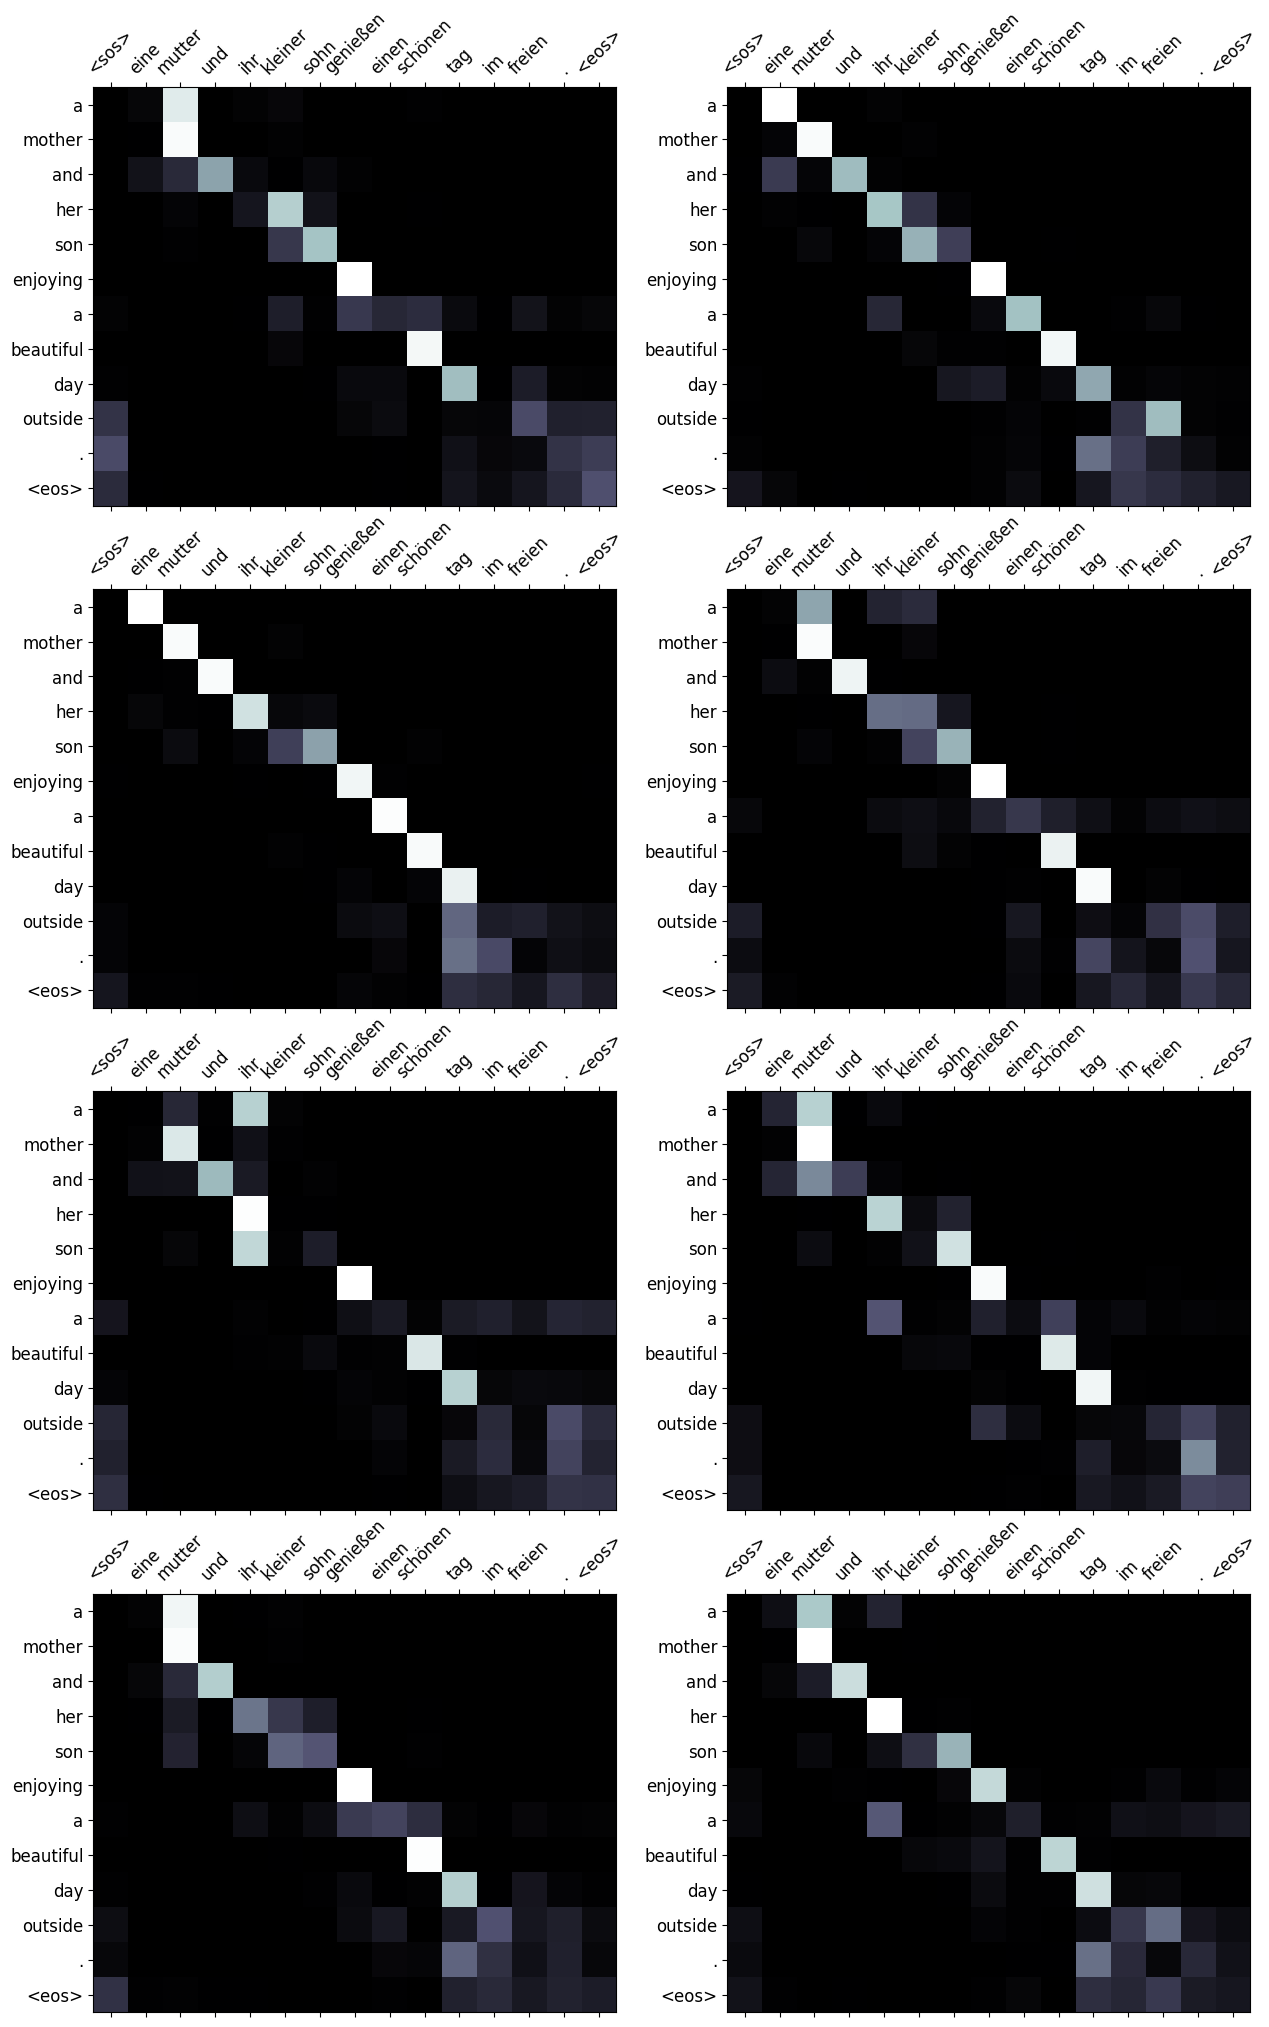

In [41]:
# Display attention map 
display_attention(src, translation, attention)

#### <b>Calculate BLEU Score </b>

* Calculate BLEU score of trained Transformer Model

In [42]:
def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # exclude last <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"Prediction: {pred_trg}")
            print(f"Correct answer: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [43]:
# Test results and BLEU score 
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
Prediction: ['a', 'group', 'of', 'asian', 'children', 'are', 'sitting', 'in', 'blue', 'chairs', 'while', 'sitting', 'on', 'blue', 'chairs', '.']
Correct answer: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[200/1000]
Prediction: ['all', 'all', 'group', 'of', 'people', 'stand', 'under', 'umbrellas', '.']
Correct answer: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[300/1000]
Prediction: ['a', 'young', 'girl', 'in', 'a', 'yellow', 'jersey', 'is', 'helping', 'the', 'goal', '.']
Correct answer: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[400/1000]
Prediction: ['two', 'young', 'children', 'are', 'on', 'the', 'sand', '.']
Correct answer: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[500/1000]
Prediction: ['two', 'brown', 'dogs', 'running', 'across', 'the', 'snow', '.']
Correct answer: ['two', 'medium', 'sized', 'dogs', 'run', 'a